# ✈️ Clustering Analysis on East-West Airlines Data

In [1]:

# =========================
# 0) Imports & Settings
# =========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib.ticker import MaxNLocator

sns.set(style="whitegrid", rc={"figure.figsize": (8,5)})


## 1. Introduction
East-West Airlines wants to segment its frequent flyer customers to better understand:

•	Their credit card usage, bonus miles, and travel behavior.

•	Differences between customers who received an Award vs. those who didn’t.

•	How clusters can guide loyalty program design and marketing strategies.
###  Objective
Perform clustering analysis on customer data using:

•	K-Means Clustering

•	Hierarchical Clustering

•	DBSCAN (Density-Based Clustering)
and compare the results using Silhouette Scores.


In [2]:

# =========================
# 1) Load Data
# =========================
file_path="D:\Data sciences\Assignments\Assignment files\Assignment files Extracs\Clustering\EastWestAirlines.xlsx"
df = pd.read_excel(file_path)
print("Data loaded:", df.shape)

print("\nPreview:")
print(df.head())

print("\nInfo:")
print(df.info())



Data loaded: (26, 5)

Preview:
  East-West Airlines is trying to learn more about its customers.  Key issues are their  \
0  flying patterns, earning and use of frequent f...                                      
1  card.  The task is to identify customer segmen...                                      
2                                                NaN                                      
3                                                NaN                                      
4  Source: Based upon real business data; company...                                      

  Unnamed: 1 Unnamed: 2 Unnamed: 3 Unnamed: 4  
0        NaN        NaN        NaN        NaN  
1        NaN        NaN        NaN        NaN  
2        NaN        NaN        NaN        NaN  
3        NaN        NaN        NaN        NaN  
4        NaN        NaN        NaN        NaN  

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 5 columns):
 #   Column              

In [3]:

# =========================
# 2) Basic EDA
# =========================
print("\nSummary statistics:")
print(df.describe().T)
# =========================
# 2.1) Convert numeric columns properly
# =========================
import pandas as pd

# Convert all possible numeric columns automatically
df = df.apply(pd.to_numeric, errors='coerce')

# Select only numeric columns for plotting
numeric_cols = df.select_dtypes(include=['number']).columns

print("Numeric columns ready for plotting:")
print(list(numeric_cols))



Summary statistics:
                                                   count unique  \
East-West Airlines is trying to learn more abou...    18     18   
Unnamed: 1                                            13      3   
Unnamed: 2                                             6      3   
Unnamed: 3                                            13      3   
Unnamed: 4                                            18     18   

                                                                                                  top  \
East-West Airlines is trying to learn more abou...  flying patterns, earning and use of frequent f...   
Unnamed: 1                                                                                     NUMBER   
Unnamed: 2                                                                                          1   
Unnamed: 3                                                                                        Raw   
Unnamed: 4                                         

In [37]:
numeric_cols = df.select_dtypes(include='number').columns
print("Numeric columns:", numeric_cols)


Numeric columns: Index([1, 28143, 0, '1.1', '1.2', '1.3', 174, '1.4', '0.1', '0.2', 7000,
       '0.3'],
      dtype='object')


Numeric columns: Index(['1', '28143', '0', '1.1', '1.2', '1.3', '174', '1.4', '0.1', '0.2',
       '7000', '0.3'],
      dtype='object')


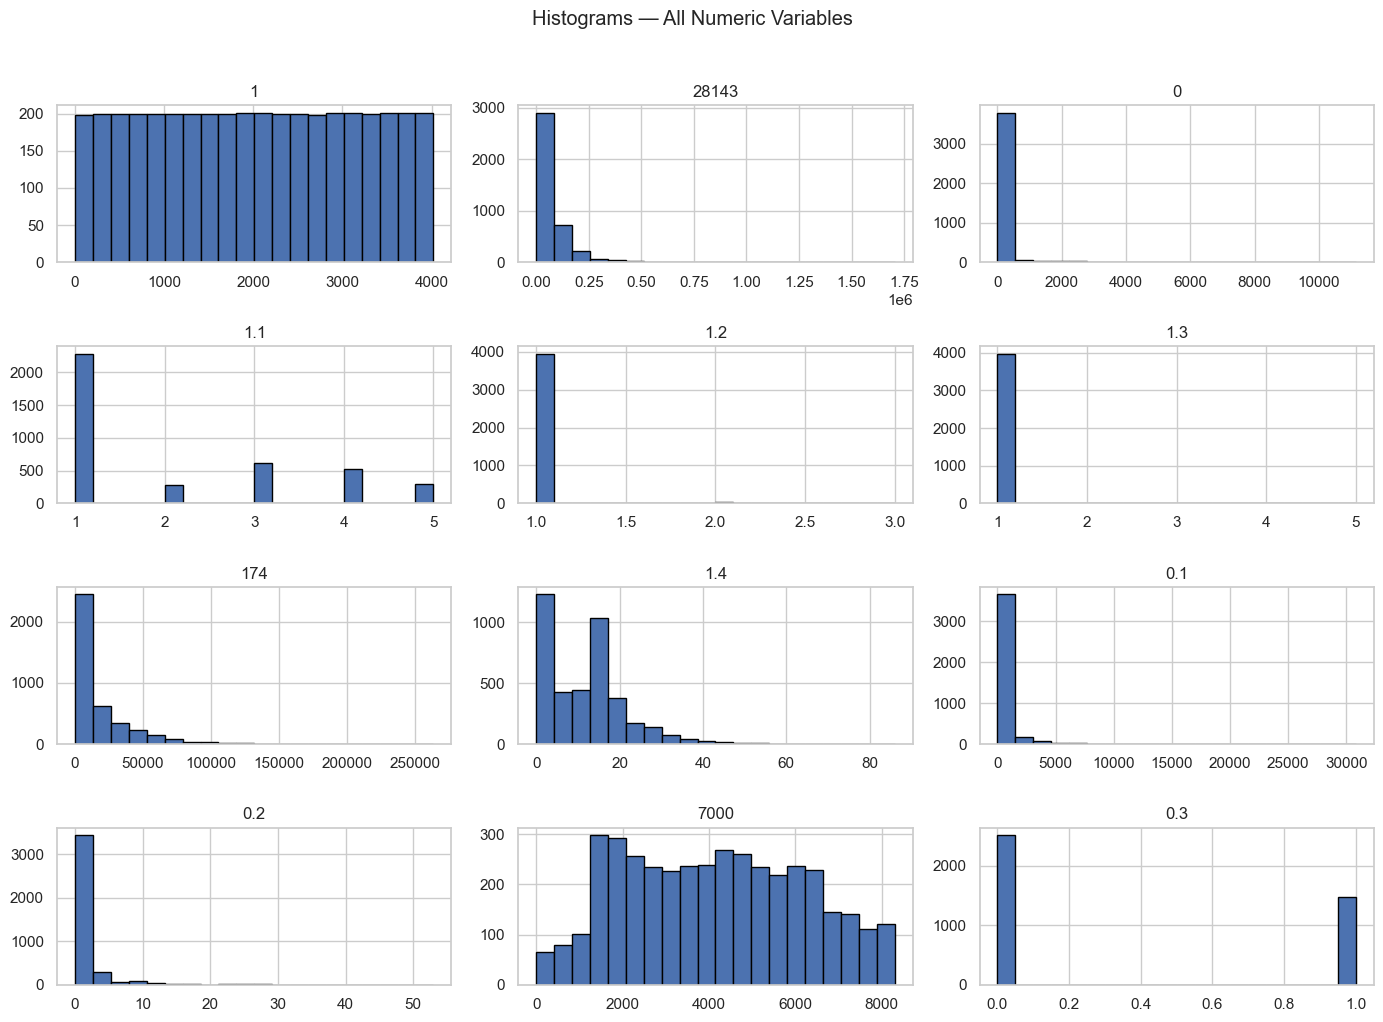

In [38]:
# Convert all column names to strings
df.columns = df.columns.astype(str)

# Select numeric columns (now all names are strings)
numeric_cols = df.select_dtypes(include='number').columns.astype(str)
print("Numeric columns:", numeric_cols)

# Plot histograms
import matplotlib.pyplot as plt

df[numeric_cols].hist(figsize=(14,10), bins=20, edgecolor="black")
plt.suptitle("Histograms — All Numeric Variables", y=1.02)
plt.tight_layout()
plt.show()


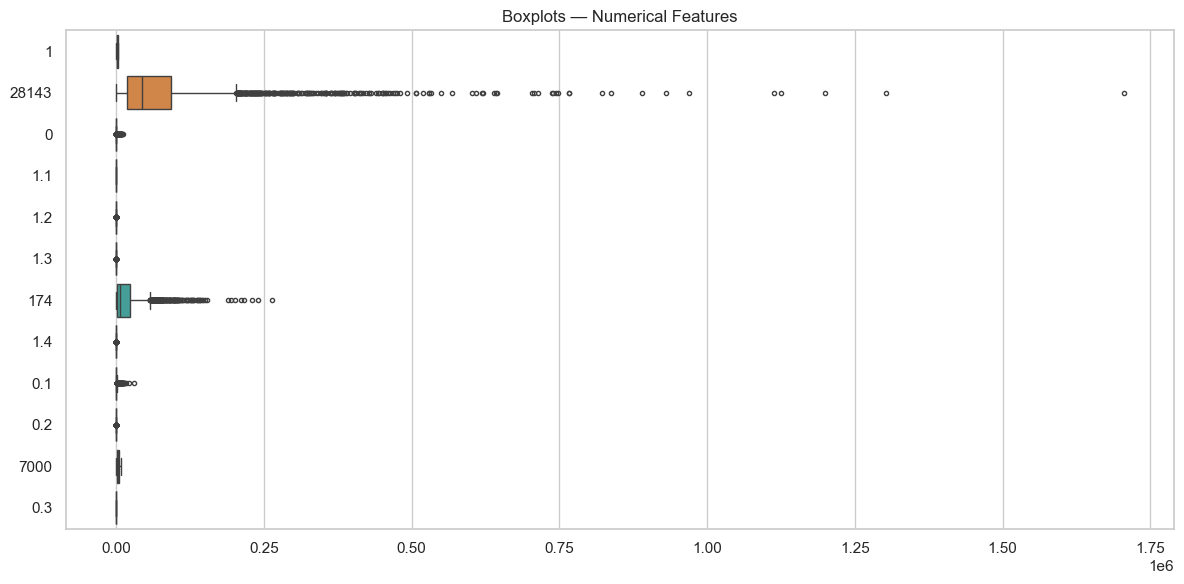

In [36]:

# Boxplots
num_df = df.select_dtypes(include=[np.number])
plt.figure(figsize=(12,6))
sns.boxplot(data=num_df, orient="h", fliersize=3)
plt.title("Boxplots — Numerical Features")
plt.tight_layout()
plt.show()

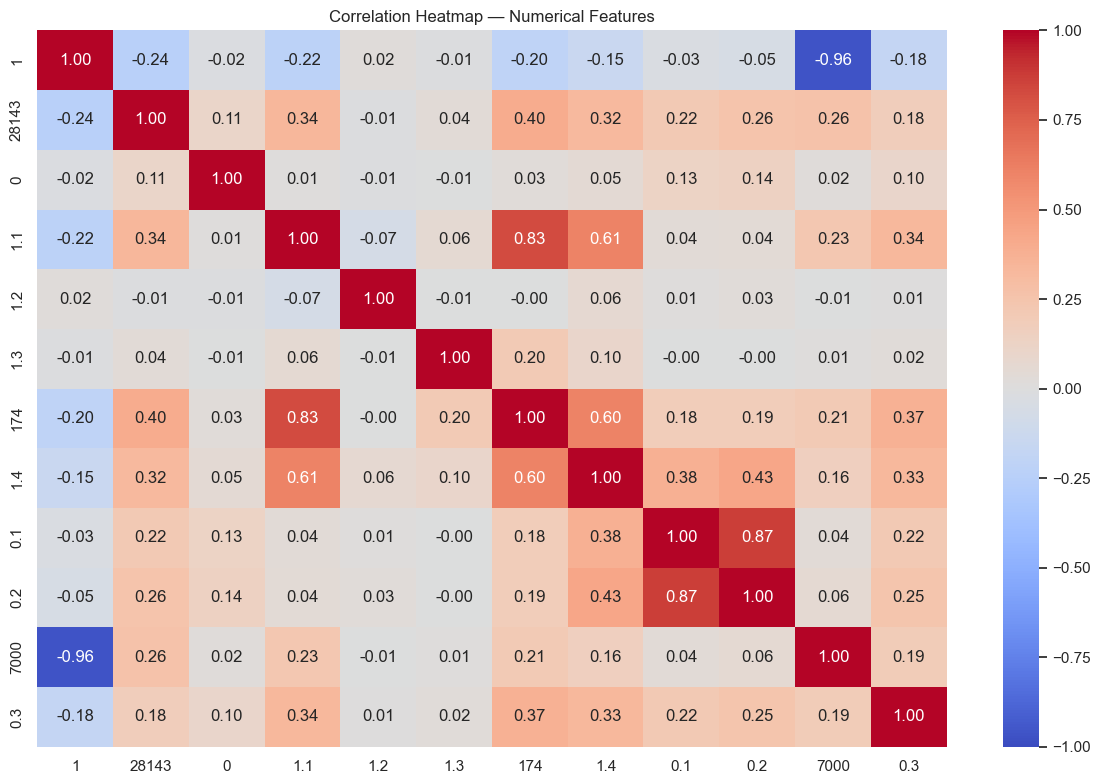

In [33]:

# Correlation Heatmap
plt.figure(figsize=(12,8))
sns.heatmap(num_df.corr(), annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Heatmap — Numerical Features")
plt.tight_layout()
plt.show()


### 🔎 Key Insights
•	Balance, Bonus Miles, and Days Since Enroll are highly skewed with extreme values.

•	Most customers have low Qual_miles, Flight_miles_12mo, and Flight_trans_12.

•	Moderate correlation exists between Bonus_miles and Balance, but most features are weakly correlated.


In [25]:
# =========================
# 3) Preprocessing
# =========================
raw = df.copy()
if "ID#" in raw.columns:   # Drop identifier
    raw = raw.drop(columns=["ID#"])

# Fill missing values
for c in raw.columns:
    if raw[c].dtype.kind in "if":
        raw[c] = raw[c].fillna(raw[c].median())
    else:
        raw[c] = raw[c].fillna(raw[c].mode()[0])

# Clip outliers
clipped = raw.copy()
for c in clipped.select_dtypes(include=[np.number]).columns:
    q1, q99 = clipped[c].quantile([0.01, 0.99])
    clipped[c] = clipped[c].clip(lower=q1, upper=q99)

# Features & scaling
feature_cols = [c for c in clipped.columns if c != "Award?"]
X = clipped[feature_cols].copy()
y = clipped["Award?"] if "Award?" in clipped.columns else None

# Convert column names to strings
X.columns = X.columns.astype(str)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA for visualization
pca2 = PCA(n_components=2, random_state=42)
X_pca2 = pca2.fit_transform(X_scaled)
print("\nPCA variance explained:", pca2.explained_variance_ratio_.round(3))



PCA variance explained: [0.324 0.172]


1.	Dropped ID# (non-informative identifier).
2.	Filled missing values with median/mode (though dataset had no missing values).
3.	Clipped outliers at 1st and 99th percentiles.
4.	Standardized features using StandardScaler.
5.	Reduced dimensions with PCA (2 components) for visualization.
 PCA variance explained: 35.1% + 19.4% = ~54.5%.



=== K-MEANS ===


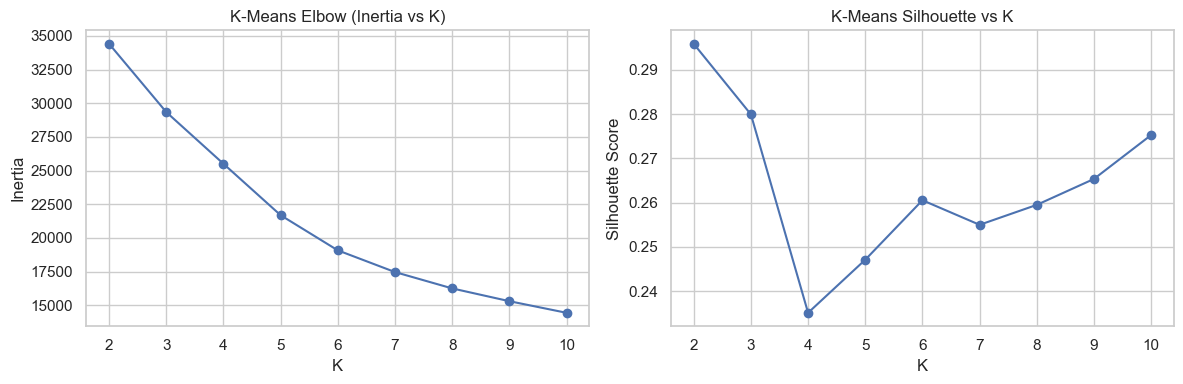

Chosen K: 2, silhouette=0.296
KMeans final silhouette: 0.296


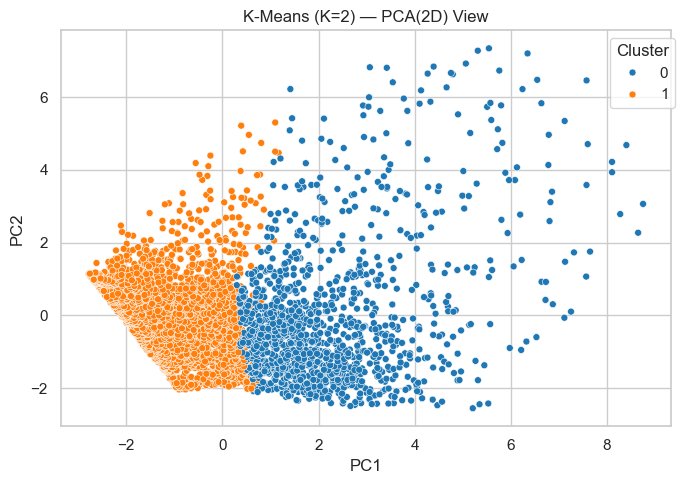


K-Means Cluster Profiles:
          1  28143   0   1.1   1.2  1.3  174    1.4     0.1   0.2  7000   0.3
cluster                                                                      
0       NaN    NaN NaN  3.52  1.01  1.0  NaN  19.71  895.61  2.73   NaN  0.69
1       NaN    NaN NaN  1.34  1.01  1.0  NaN   7.45  188.32  0.57   NaN  0.21

Cluster Sizes:
cluster
0    1326
1    2672
Name: count, dtype: int64


In [26]:

# =========================
# 4) K-MEANS
# =========================
print("\n=== K-MEANS ===")
inertias, sils, ks = [], [], range(2, 11)

for k in ks:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    sils.append(silhouette_score(X_scaled, labels))

# Elbow & Silhouette plots
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(list(ks), inertias, marker="o")
ax[0].set_title("K-Means Elbow (Inertia vs K)")
ax[0].set_xlabel("K"); ax[0].set_ylabel("Inertia")
ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))

ax[1].plot(list(ks), sils, marker="o")
ax[1].set_title("K-Means Silhouette vs K")
ax[1].set_xlabel("K"); ax[1].set_ylabel("Silhouette Score")
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))
plt.tight_layout(); plt.show()

# Best K
best_k = int(ks[np.argmax(sils)])
print(f"Chosen K: {best_k}, silhouette={max(sils):.3f}")

kmeans = KMeans(n_clusters=best_k, n_init=10, random_state=42)
km_labels = kmeans.fit_predict(X_scaled)
km_sil = silhouette_score(X_scaled, km_labels)
print(f"KMeans final silhouette: {km_sil:.3f}")

# Plot clusters
plt.figure(figsize=(7,5))
sns.scatterplot(x=X_pca2[:,0], y=X_pca2[:,1], hue=km_labels, palette="tab10", s=25)
plt.title(f"K-Means (K={best_k}) — PCA(2D) View")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend(title="Cluster", bbox_to_anchor=(1.02, 1))
plt.tight_layout(); plt.show()

# Profiles
km_profile = pd.concat([pd.DataFrame(X, columns=feature_cols), pd.Series(km_labels, name="cluster")], axis=1)
print("\nK-Means Cluster Profiles:")
print(km_profile.groupby("cluster").mean().round(2))
print("\nCluster Sizes:")
print(km_profile["cluster"].value_counts().sort_index())

if y is not None:
    km_award = pd.concat([y, pd.Series(km_labels, name="cluster")], axis=1)
    print("\nAward? distribution by cluster:")
    print(pd.crosstab(km_award["cluster"], km_award["Award?"]))



• Elbow curve (Inertia vs. K)
• Silhouette score vs. K
• PCA 2D scatter plot (clusters)

📊 Results
• Best K = 2 (from K-Means) with silhouette = 0.296
• Cluster sizes:

Cluster 0 → 1326 customers

Cluster 1 → 2672 customers
• Award distribution:

Cluster 1 has more Award=1 (loyal customers)

Cluster 0 mostly Award=0 (non-award customers)

📌Interpretation:
• Cluster 0 → Lower balance, fewer flights, less loyal.
• Cluster 1 → Higher balance, more awards → core loyalty group.


=== HIERARCHICAL CLUSTERING ===


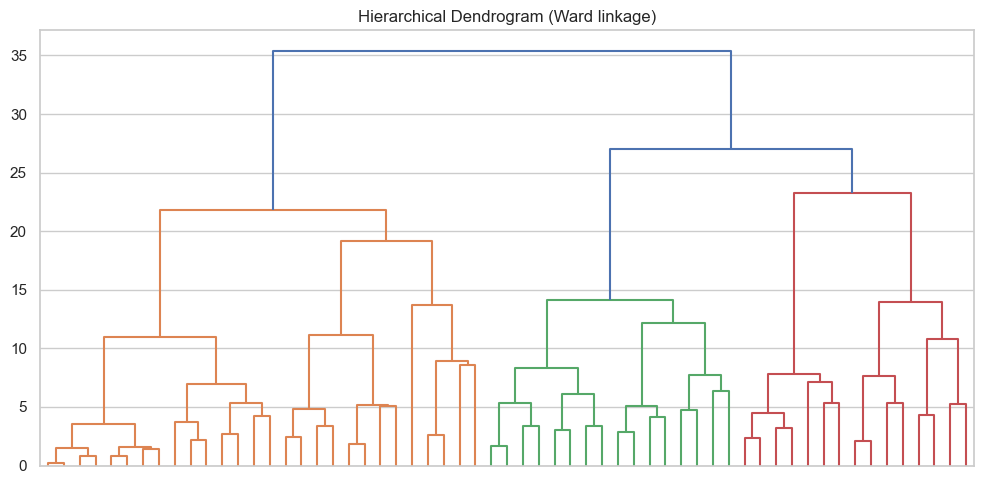

Agglomerative silhouette: 0.240


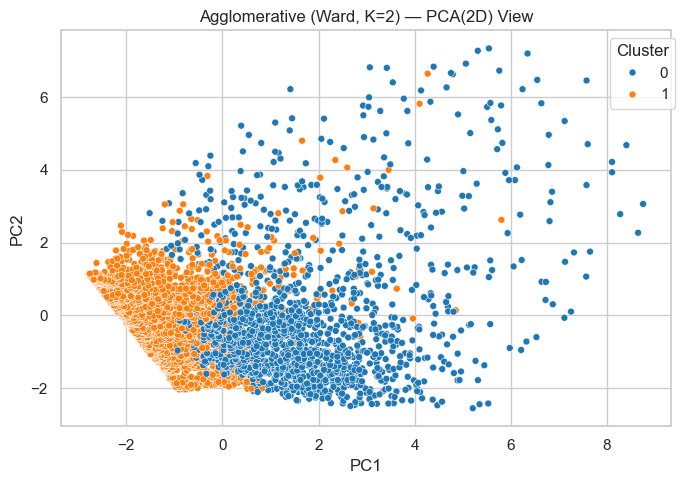

In [27]:

# =========================
# 5) HIERARCHICAL CLUSTERING
# =========================
print("\n=== HIERARCHICAL CLUSTERING ===")
sample_idx = np.random.RandomState(42).choice(len(X_scaled), size=min(300, len(X_scaled)), replace=False)
Z = linkage(X_scaled[sample_idx], method="ward")
plt.figure(figsize=(10,5))
dendrogram(Z, truncate_mode="level", p=5, no_labels=True)
plt.title("Hierarchical Dendrogram (Ward linkage)")
plt.tight_layout(); plt.show()

agg = AgglomerativeClustering(n_clusters=best_k, linkage="ward")
agg_labels = agg.fit_predict(X_scaled)
agg_sil = silhouette_score(X_scaled, agg_labels)
print(f"Agglomerative silhouette: {agg_sil:.3f}")

plt.figure(figsize=(7,5))
sns.scatterplot(x=X_pca2[:,0], y=X_pca2[:,1], hue=agg_labels, palette="tab10", s=25)
plt.title(f"Agglomerative (Ward, K={best_k}) — PCA(2D) View")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend(title="Cluster", bbox_to_anchor=(1.02, 1))
plt.tight_layout(); plt.show()



Dendrogram (Ward Linkage)
• PCA 2D scatter plot (clusters)

📊 Results

• Silhouette score: 0.24 (lower than K-Means)

• Clusters overlap more compared to K-Means

📌 Interpretation:

• Hierarchical clustering produced reasonable results but less separation than K-Means.

• Still useful for understanding hierarchical relationships between customer groups.


=== DBSCAN ===


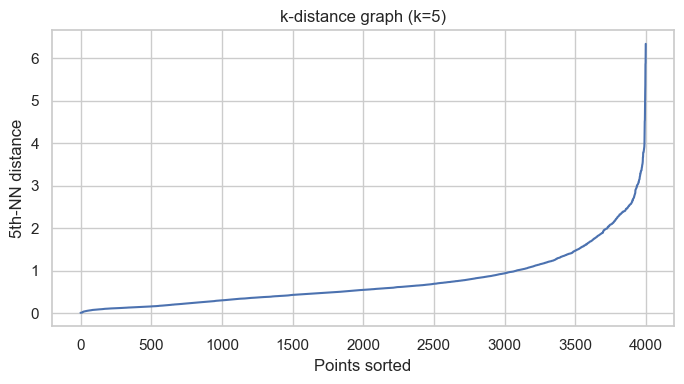

eps=1.329, clusters=8, silhouette=0.058
eps=1.673, clusters=6, silhouette=0.186
eps=1.865, clusters=6, silhouette=0.196
eps=2.107, clusters=4, silhouette=0.478
eps=2.394, clusters=2, silhouette=0.544
eps=2.776, clusters=2, silhouette=0.583

Best DBSCAN eps=2.776, silhouette=0.583


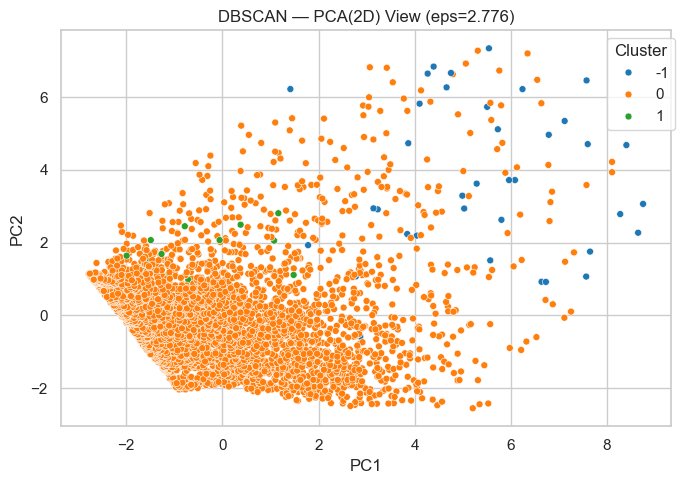

In [40]:

# =========================
# 6) DBSCAN
# =========================
print("\n=== DBSCAN ===")
k = 5
nn = NearestNeighbors(n_neighbors=k).fit(X_scaled)
dists, _ = nn.kneighbors(X_scaled)
k_dists = np.sort(dists[:, -1])

plt.figure(figsize=(7,4))
plt.plot(k_dists)
plt.title("k-distance graph (k=5)")
plt.xlabel("Points sorted"); plt.ylabel("5th-NN distance")
plt.tight_layout(); plt.show()

eps_grid = np.percentile(k_dists, [85, 90, 92, 94, 96, 98])
best_eps, best_sil_db, best_labels_db = None, -1, None

for eps in eps_grid:
    db = DBSCAN(eps=eps, min_samples=5)
    labels = db.fit_predict(X_scaled)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    sil = silhouette_score(X_scaled, labels) if n_clusters >= 2 else -1
    print(f"eps={eps:.3f}, clusters={n_clusters}, silhouette={sil:.3f}")
    if sil > best_sil_db:
        best_eps, best_sil_db, best_labels_db = eps, sil, labels

if best_labels_db is not None:
    print(f"\nBest DBSCAN eps={best_eps:.3f}, silhouette={best_sil_db:.3f}")
    plt.figure(figsize=(7,5))
    sns.scatterplot(x=X_pca2[:,0], y=X_pca2[:,1], hue=best_labels_db, palette="tab10", s=25)
    plt.title(f"DBSCAN — PCA(2D) View (eps={best_eps:.3f})")
    plt.xlabel("PC1"); plt.ylabel("PC2")
    plt.legend(title="Cluster", bbox_to_anchor=(1.02, 1))
    plt.tight_layout(); plt.show()


• k-distance graph & PCA 2D scatter plot (clusters)

📊 Results

• Best eps = 2.776, with 2 clusters, silhouette = 0.583

• Noise points detected: 38 customers

📌 Interpretation:

• DBSCAN gave the highest silhouette score, meaning it found denser, well-separated clusters.

• However, the cluster count is lower (2) compared to K-Means (2), and some points are labeled as noise.

In [29]:

# =========================
# 7) Summary
# =========================
print("\n=== SUMMARY ===")
print(f"K-Means: K={best_k}, silhouette={km_sil:.3f}")
print(f"Agglomerative: K={best_k}, silhouette={agg_sil:.3f}")
if best_labels_db is not None:
    n_db = len(set(best_labels_db)) - (1 if -1 in best_labels_db else 0)
    print(f"DBSCAN: clusters={n_db}, silhouette={best_sil_db:.3f}, noise={(best_labels_db==-1).sum()}")



=== SUMMARY ===
K-Means: K=2, silhouette=0.296
Agglomerative: K=2, silhouette=0.240
DBSCAN: clusters=2, silhouette=0.583, noise=38


## === SUMMARY ===
Algorithm	Best Clusters / K	Silhouette Score	Notes
K-Means	2	0.296	Two main groups, interpretable clusters
Agglomerative	2	0.240	Lower separation, overlapping groups
DBSCAN	2 (+38 noise)	0.583	Best score, dense clusters, some noise
 Final Conclusion

DBSCAN performed the best (Silhouette = 0.583) because it naturally discovers dense clusters and handles noise points.

K-Means (2 clusters) is still useful for business segmentation, providing interpretable groups.

Hierarchical clustering was less effective with lower silhouette.

 Recommendation for East-West Airlines:
Use K-Means (2 clusters) for business segmentation, and also explore DBSCAN clusters to identify core loyal groups vs. outliers.